<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2020 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import os

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import seaborn as sns
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from sklearn import decomposition
from sklearn.metrics.cluster import contingency_matrix
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

init_notebook_mode(connected=True)

In [3]:
def save_skills_graph(skills_ratings, clusters, bool_crack, folder_path='imagenes/temporal/' ):
    for i in range(len(skills_ratings)):
        for j in range(i + 1, len(skills_ratings)):
            #Eligo dos números entre 0 y  de n_skills-1
            skill_1 = skills_ratings[i]
            skill_2 = skills_ratings[j]

            kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                                        mode='markers',
                                        text=df_n.loc[:,'team_position'], # 'height', 'weight', 'club', 'age', 'short_name', 'position'
                                        marker=dict(
                                            size=5,
                                            color = clusters.astype(np.float), #set color equal to a variable
                                            colorscale='Portland',
                                            showscale=False)
                                       )

            crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                                  text=df_n.loc[bool_crack,'short_name'],
                                  textfont=dict(family='sans serif',size=10,color='black'),
                                  opacity=0.9,mode='text')

            data=[kmean_clusters,crack]

            layout = go.Layout(title="Clustering K means - K = {} ".format(n_clust),titlefont=dict(size=20),
                            xaxis=dict(title=skill_1),
                            yaxis=dict(title=skill_2),
                            autosize=False, width=1000,height=1000)

            fig = go.Figure(data=data, layout=layout)

            file_path = folder_path + '{}_vs_{}.png'.format(skill_1, skill_2)
            if not os.path.exists(file_path):
                #iplot(fig)
                fig.write_image(file_path)
                

def player_positions_series_from_group( df, group_label, col_position = 'player_positions' ):
    array=[]
    group = df[df.group_label == group_label]
    for x in group[col_position]:
        array.extend(x.split(', '))    
    return pd.Series(array)

def get_colum_series_by_group(df, column_name, group_label):
    return df[df.group_label == group_label][column_name]

def print_Silohuette(n_clusters, cluster_labels, df_skills, title):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (n_clusters + 1) * 10])

    #cluster_labels = km.labels_

    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))    
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((title),
                 fontsize=14, fontweight='bold')

    plt.show()

    
def print_kmeans_inertia(df_skills, cluster_range=10):
    scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(cluster_range)]

    plt.plot(np.arange(2, 12), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")
    plt.show()

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("players_20.csv")
df.describe()
null_columns = df.columns[df.isnull().any()]
null_columns

Index(['release_clause_eur', 'player_tags', 'team_position',
       'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until',
       'nation_position', 'nation_jersey_number', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object')

In [5]:
df.isna().sum()

sofifa_id                         0
player_url                        0
short_name                        0
long_name                         0
age                               0
dob                               0
height_cm                         0
weight_kg                         0
nationality                       0
club                              0
overall                           0
potential                         0
value_eur                         0
wage_eur                          0
player_positions                  0
preferred_foot                    0
international_reputation          0
weak_foot                         0
skill_moves                       0
work_rate                         0
body_type                         0
real_face                         0
release_clause_eur             1298
player_tags                   16779
team_position                   240
team_jersey_number              240
loaned_from                   17230
joined                      

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [6]:
n = 10000  # cantidad de jugadores a considerar

df_n = df.loc[:n]  # se reduce la base a los n primeros jugadores

df_n = df_n[(df_n.overall > 70)]

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

df_skills=df_n[skills_ratings]
df_skills.isna().sum()
df_skills = df_skills.fillna(0)

40 variables numéricas de desempeño según habilidad


In [7]:
df[df.passing.isna()].player_positions.value_counts()

GK    2036
Name: player_positions, dtype: int64

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [8]:
# Número de clusters buscado
n_cluster_kmean = 4

km = KMeans(n_clusters=n_cluster_kmean, random_state=10)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

clusterer = KMeans(n_clusters=n_cluster_kmean, random_state=10)
cluster_labels = clusterer.fit_predict(df_skills)
clusters

Suma de los cuadrados de las distancias al cluster / Inertia:  12248167.979694199


array([0, 0, 0, ..., 2, 2, 3], dtype=int32)

**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

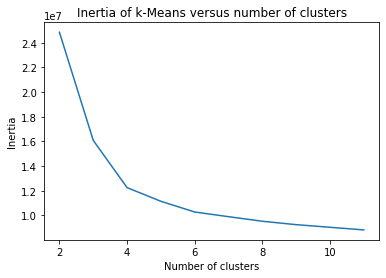

In [9]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
print_kmeans_inertia(df_skills)

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [10]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                            mode='markers',
                            text=df_n.loc[:,'team_position'],
                            marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'team_position'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means - K = {} ".format(n_cluster_kmean),titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [11]:
df_cluster_kmean=df_n.copy()
df_cluster_kmean['group_label'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette? https://es.qwe.wiki/wiki/Silhouette_(clustering)


### Cantidad de observaciones por Cluster

In [12]:
df_cluster_count = df_cluster_kmean.groupby(by=['group_label']).count()[['sofifa_id']]
df_cluster_count.columns = ['observaciones']
df_cluster_count

,observaciones
group_label,
0,1659
1,440
2,1734
3,923


### Tabla de contingencia. Variable Categórica vs Cluster

In [13]:
pd.crosstab(index=df_cluster_kmean['team_position'],
            columns=df_cluster_kmean['group_label'], margins=True)

group_label,0,1,2,3,All
team_position,,,,,
CAM,99,0,49,0,148
CB,0,0,6,34,40
CDM,1,0,68,13,82
CF,7,0,2,0,9
CM,2,0,26,2,30
GK,0,279,0,0,279
LAM,12,0,1,0,13
LB,0,0,151,13,164
LCB,0,0,33,223,256


Text(0.5, 1.0, 'Grupo 3')

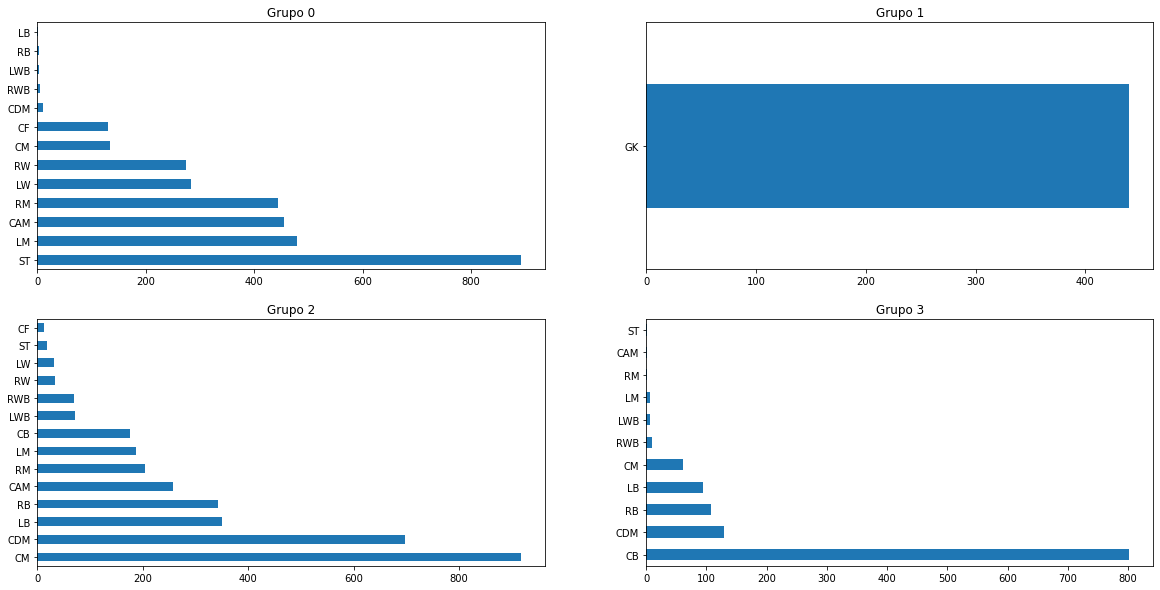

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_cluster_kmean, 0).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][0] )
axs[0][0].set_title('Grupo 0')
player_positions_series_from_group(df_cluster_kmean, 1).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][1] )
axs[0][1].set_title('Grupo 1')
player_positions_series_from_group(df_cluster_kmean, 2).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][0] )
axs[1][0].set_title('Grupo 2')
player_positions_series_from_group(df_cluster_kmean, 3).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][1] )
axs[1][1].set_title('Grupo 3')

<AxesSubplot:>

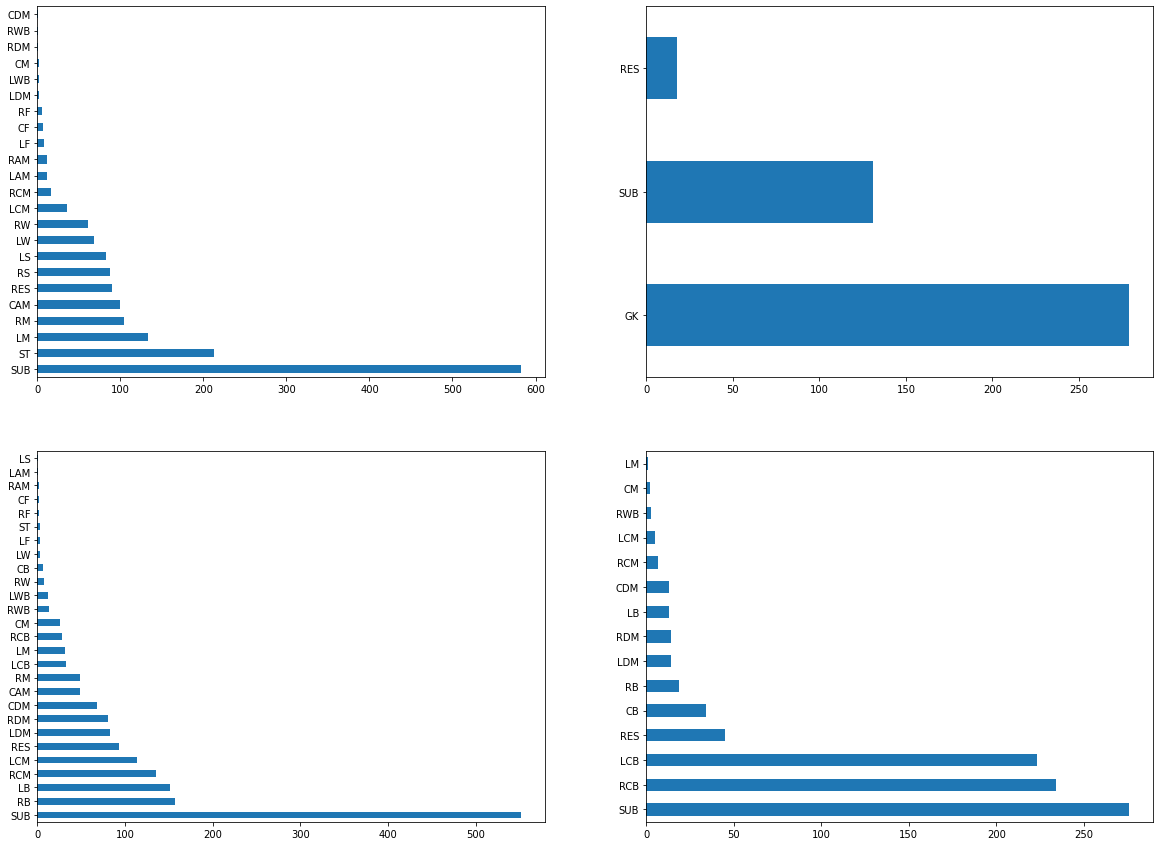

In [15]:
column = 'team_position'
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharey=False)

get_colum_series_by_group(df_cluster_kmean, column, 0).value_counts().plot(kind='barh',ax=axs[0][0])
get_colum_series_by_group(df_cluster_kmean, column, 1).value_counts().plot(kind='barh',ax=axs[0][1])
get_colum_series_by_group(df_cluster_kmean, column, 2).value_counts().plot(kind='barh',ax=axs[1][0])
get_colum_series_by_group(df_cluster_kmean, column, 3).value_counts().plot(kind='barh',ax=axs[1][1])

For n_clusters = 4 The average silhouette_score is : 0.3368326111602603


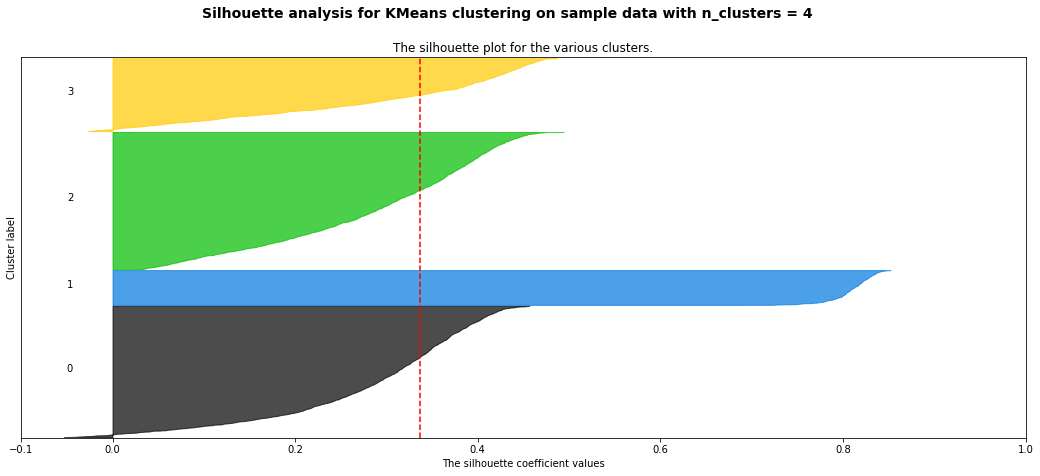

In [16]:
title = "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_cluster_kmean

print_Silohuette(n_cluster_kmean, km.labels_, df_skills, title)

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [17]:
n_samples = len(df_skills)
X = StandardScaler().fit_transform(df_skills)
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=n_samples)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
pipe = Pipeline([('scaler',RobustScaler()), ('ms',ms)] )

pipe.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_mean_shift = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_mean_shift)

Numero estimado de clusters para Mean Shift : 3


In [18]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
#skill_1=skills_ratings[5]
#skill_2=skills_ratings[14]
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [19]:
df_cluster_mean_shift=df_n.copy().fillna(0)
#df_skills = df_skills.fillna(0)
df_cluster_mean_shift['group_label'] = ms.labels_ #clusters
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

Cantidad de observaciones por Cluster

Análisis descriptivo separando por Cluster

Tabla de contingencia alguna categórica vs clusters

Silohuette?


### Cantidad de observaciones por Cluster

In [20]:
df_cluster_count = df_cluster_mean_shift.groupby(by=['group_label']).count()[['sofifa_id']]
df_cluster_count.columns = ['observaciones']
df_cluster_count

,observaciones
group_label,
0,4313
1,1
2,442


Text(0.5, 1.0, 'Grupo 2')

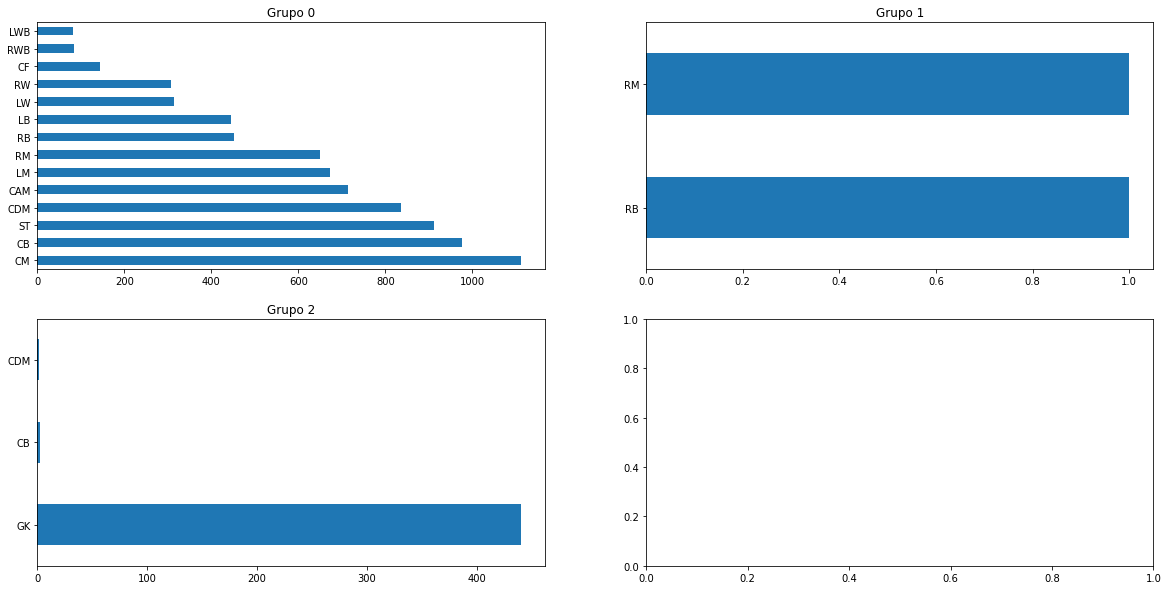

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_cluster_mean_shift, 0).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][0] )
axs[0][0].set_title('Grupo 0')
player_positions_series_from_group(df_cluster_mean_shift, 1).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][1] )
axs[0][1].set_title('Grupo 1')
player_positions_series_from_group(df_cluster_mean_shift, 2).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][0] )
axs[1][0].set_title('Grupo 2')

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,group_label
990,245297,https://sofifa.com/player/245297/giovanni-luis...,G. Quintana,Giovanni Luis Quintana,35,1984-02-29,177,75,Uruguay,Uruguay,78,78,0,0,"RB, RM",Right,1,3,3,High/Medium,Normal,No,0.0,0,0,0.0,0,0,0.0,RB,2.0,78.0,51.0,69.0,78.0,76.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,Diver,79,48,69,71,49,78,...,75,82,81,75,52,51,85,62,56,62,77,57,61,41,54,78,77,76,75,53,42,60,45,63+2,63+2,63+2,70+2,67+2,67+2,67+2,70+2,69+2,69+2,69+2,72+2,71+2,71+2,71+2,72+2,77+2,74+2,74+2,74+2,77+2,77+2,72+2,72+2,72+2,77+2,1


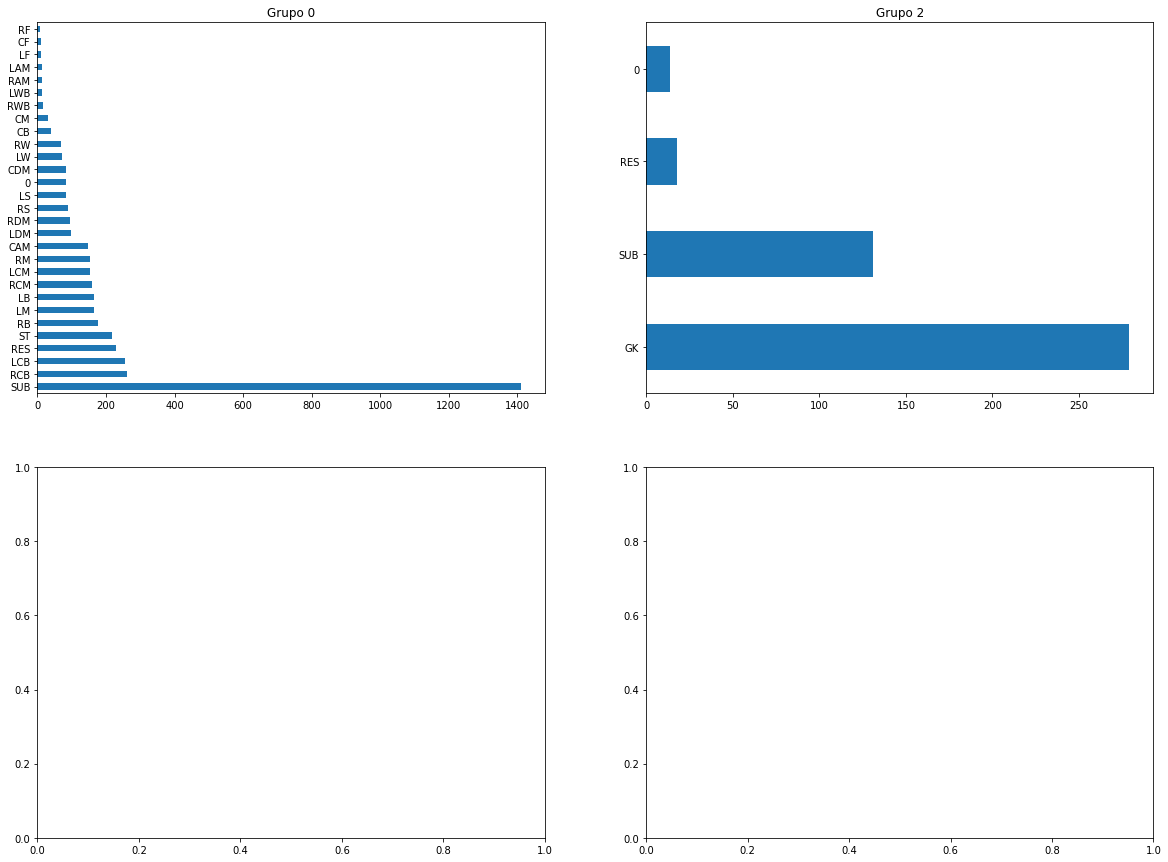

In [22]:
column = 'team_position'
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharey=False)
get_colum_series_by_group(df_cluster_mean_shift, column, 0).value_counts().plot(kind='barh',ax=axs[0][0])
axs[0][0].set_title('Grupo 0')
get_colum_series_by_group(df_cluster_mean_shift, column, 2).value_counts().plot(kind='barh',ax=axs[0][1])
axs[0][1].set_title('Grupo 2')

df_cluster_mean_shift[df_cluster_mean_shift.group_label == 1]

**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos podemos hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [23]:
df_n.head(5)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,...,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,...,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,...,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,"Flair, Acrobatic Clearance",13,11,15,43,13,12,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Selfish

In [29]:
n=10000

df_temp = df.loc[:n]
df_without_GK=df_temp[(df_temp["team_position"]!='GK')&(df_temp['overall']>69)]

#skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  ]

df_skills_without_GK=df_without_GK[skills_ratings]
df_skills_without_GK = df_skills_without_GK.fillna(0)
df_skills_without_GK.isna().sum()

attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
passing                       0
attacking_short_passing       0
attacking_volleys             0
dribbling                     0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_ball_control            0
movement_acceleration         0
movement_sprint_speed         0
movement_agility              0
movement_reactions            0
movement_balance              0
power_shot_power              0
power_jumping                 0
power_stamina                 0
power_strength                0
power_long_shots              0
mentality_aggression          0
mentality_interceptions       0
mentality_positioning         0
mentality_vision              0
mentality_penalties           0
mentality_composure           0
defending_marking             0
defending_standing_tackle     0
defending_sliding_tackle      0
dtype: int64

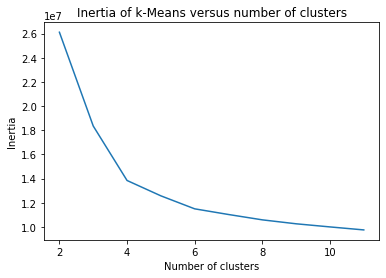

In [25]:
print_kmeans_inertia(df_skills_without_GK)

In [30]:
# Número de clusters buscado
n_clusters = 5

km_no_GK = KMeans(n_clusters=n_clusters)
km_no_GK.fit(df_skills_without_GK)

# Recuperacion de etiquetas
clusters = km_no_GK.labels_


In [33]:
data=[]
bool_crack=df_without_GK["overall"] > 85
bool_no_crack=df_without_GK["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


kmean_clusters = go.Scatter(x=df_skills_without_GK[skill_1], y=df_skills_without_GK[skill_2],
                           mode='markers',
                        text=df_without_GK.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills_without_GK.loc[bool_crack,skill_1], y=df_skills_without_GK.loc[bool_crack,skill_2],name='Top players',
                      text=df_without_GK.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [34]:
n_samples = len(df_skills_without_GK)
X = StandardScaler().fit_transform(df_skills_without_GK)
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=n_samples)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
#pipe = Pipeline([('scaler',RobustScaler()), ('ms',ms)] )
pipe = Pipeline([('scaler',RobustScaler()), ('ms',ms)] )

pipe.fit(df_skills_without_GK)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_mean_shift = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d \nBrandwidth: %d"%(n_clusters_mean_shift, bandwidth))

Numero estimado de clusters para Mean Shift : 1 
Brandwidth: 4


In [35]:
bandwidth = 2
ms_no_GK = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms_no_GK.fit(df_skills_without_GK)

clusters2 = ms_no_GK.labels_
cluster_centers = ms_no_GK.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_mean_shift = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d \nBrandwidth: %d"%(n_clusters_mean_shift, bandwidth))


Numero estimado de clusters para Mean Shift : 8 
Brandwidth: 2


In [36]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [38]:
df_km_no_GK=df_without_GK.copy()
df_ms_no_GK=df_without_GK.copy()

df_km_no_GK['group_label'] = km_no_GK.labels_
df_ms_no_GK['group_label'] = ms_no_GK.labels_



**Análisis exploratorio de las clases**

<AxesSubplot:title={'center':'Group 4'}>

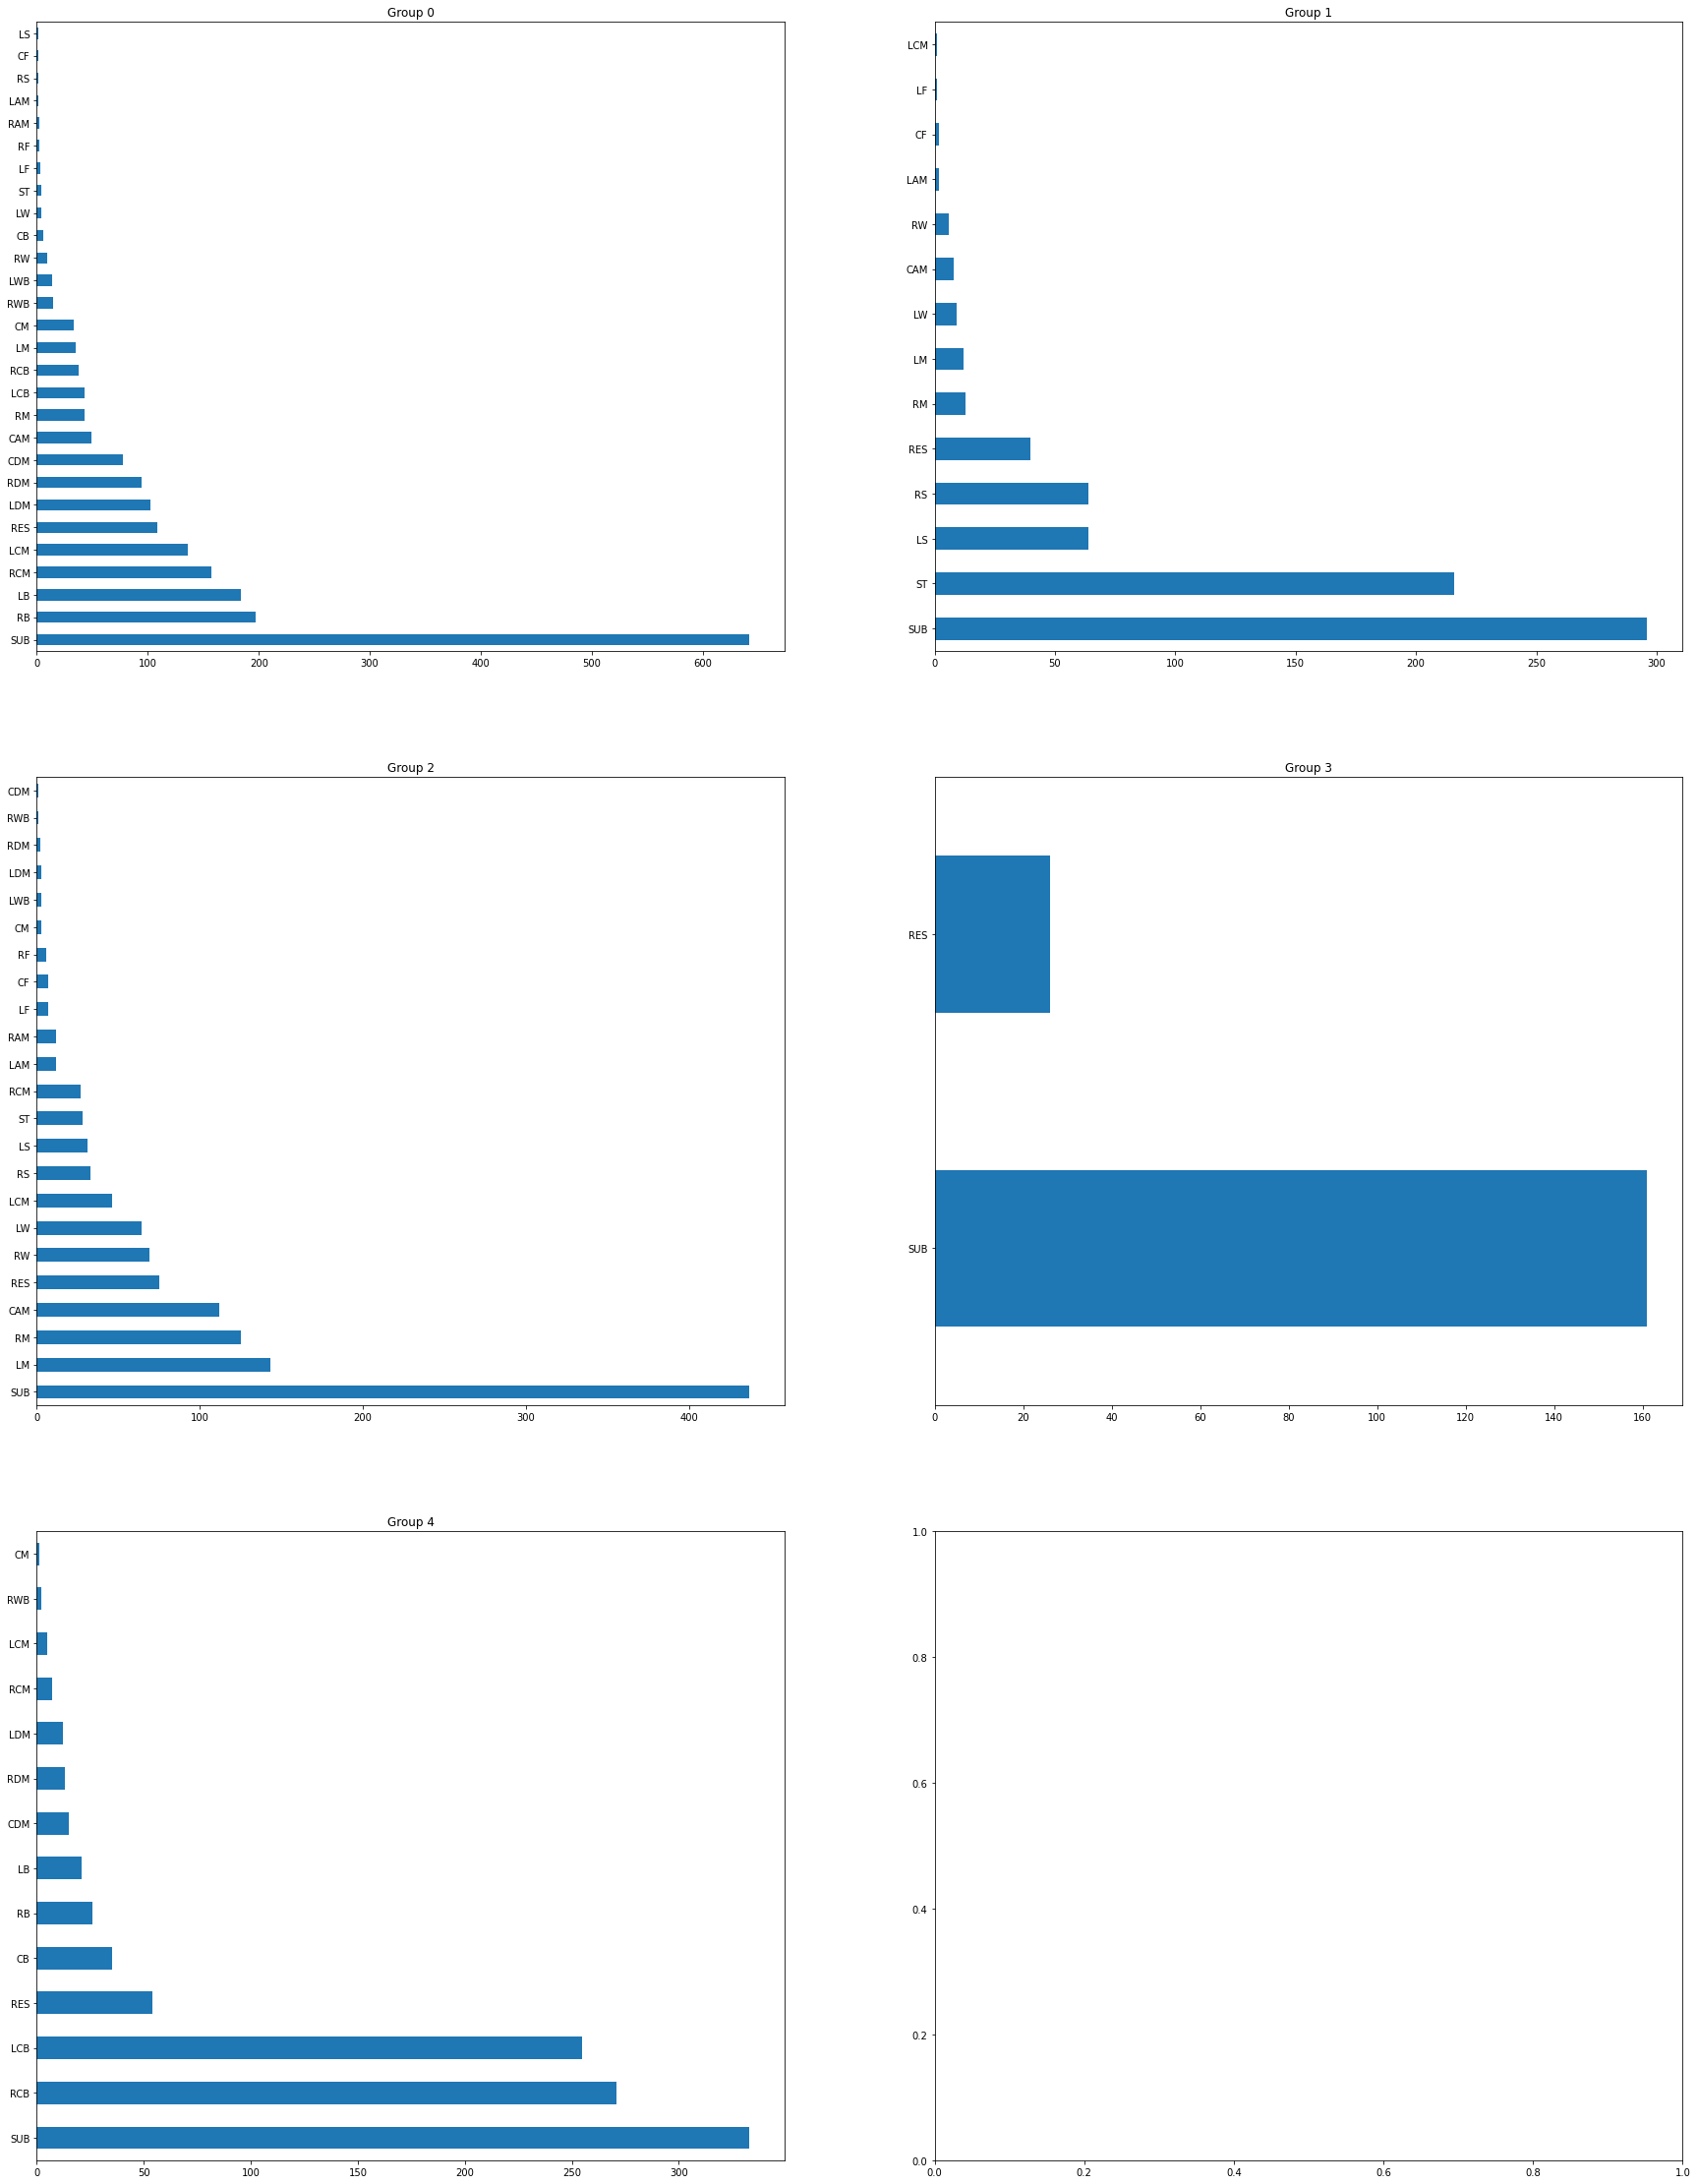

In [39]:
column_name = 'team_position'
fig, axs = plt.subplots(3, 2, figsize=(30, 40), sharey=False)
get_colum_series_by_group(df_km_no_GK, column_name, 0).value_counts().plot(kind='barh', title='Group 0', ax=axs[0][0] )
get_colum_series_by_group(df_km_no_GK, column_name, 1).value_counts().plot(kind='barh', title='Group 1', ax=axs[0][1] )
get_colum_series_by_group(df_km_no_GK, column_name, 2).value_counts().plot(kind='barh', title='Group 2', ax=axs[1][0] )
get_colum_series_by_group(df_km_no_GK, column_name, 3).value_counts().plot(kind='barh', title='Group 3', ax=axs[1][1] )
get_colum_series_by_group(df_km_no_GK, column_name, 4).value_counts().plot(kind='barh', title='Group 4', ax=axs[2][0] )

<AxesSubplot:title={'center':'Group 7'}>

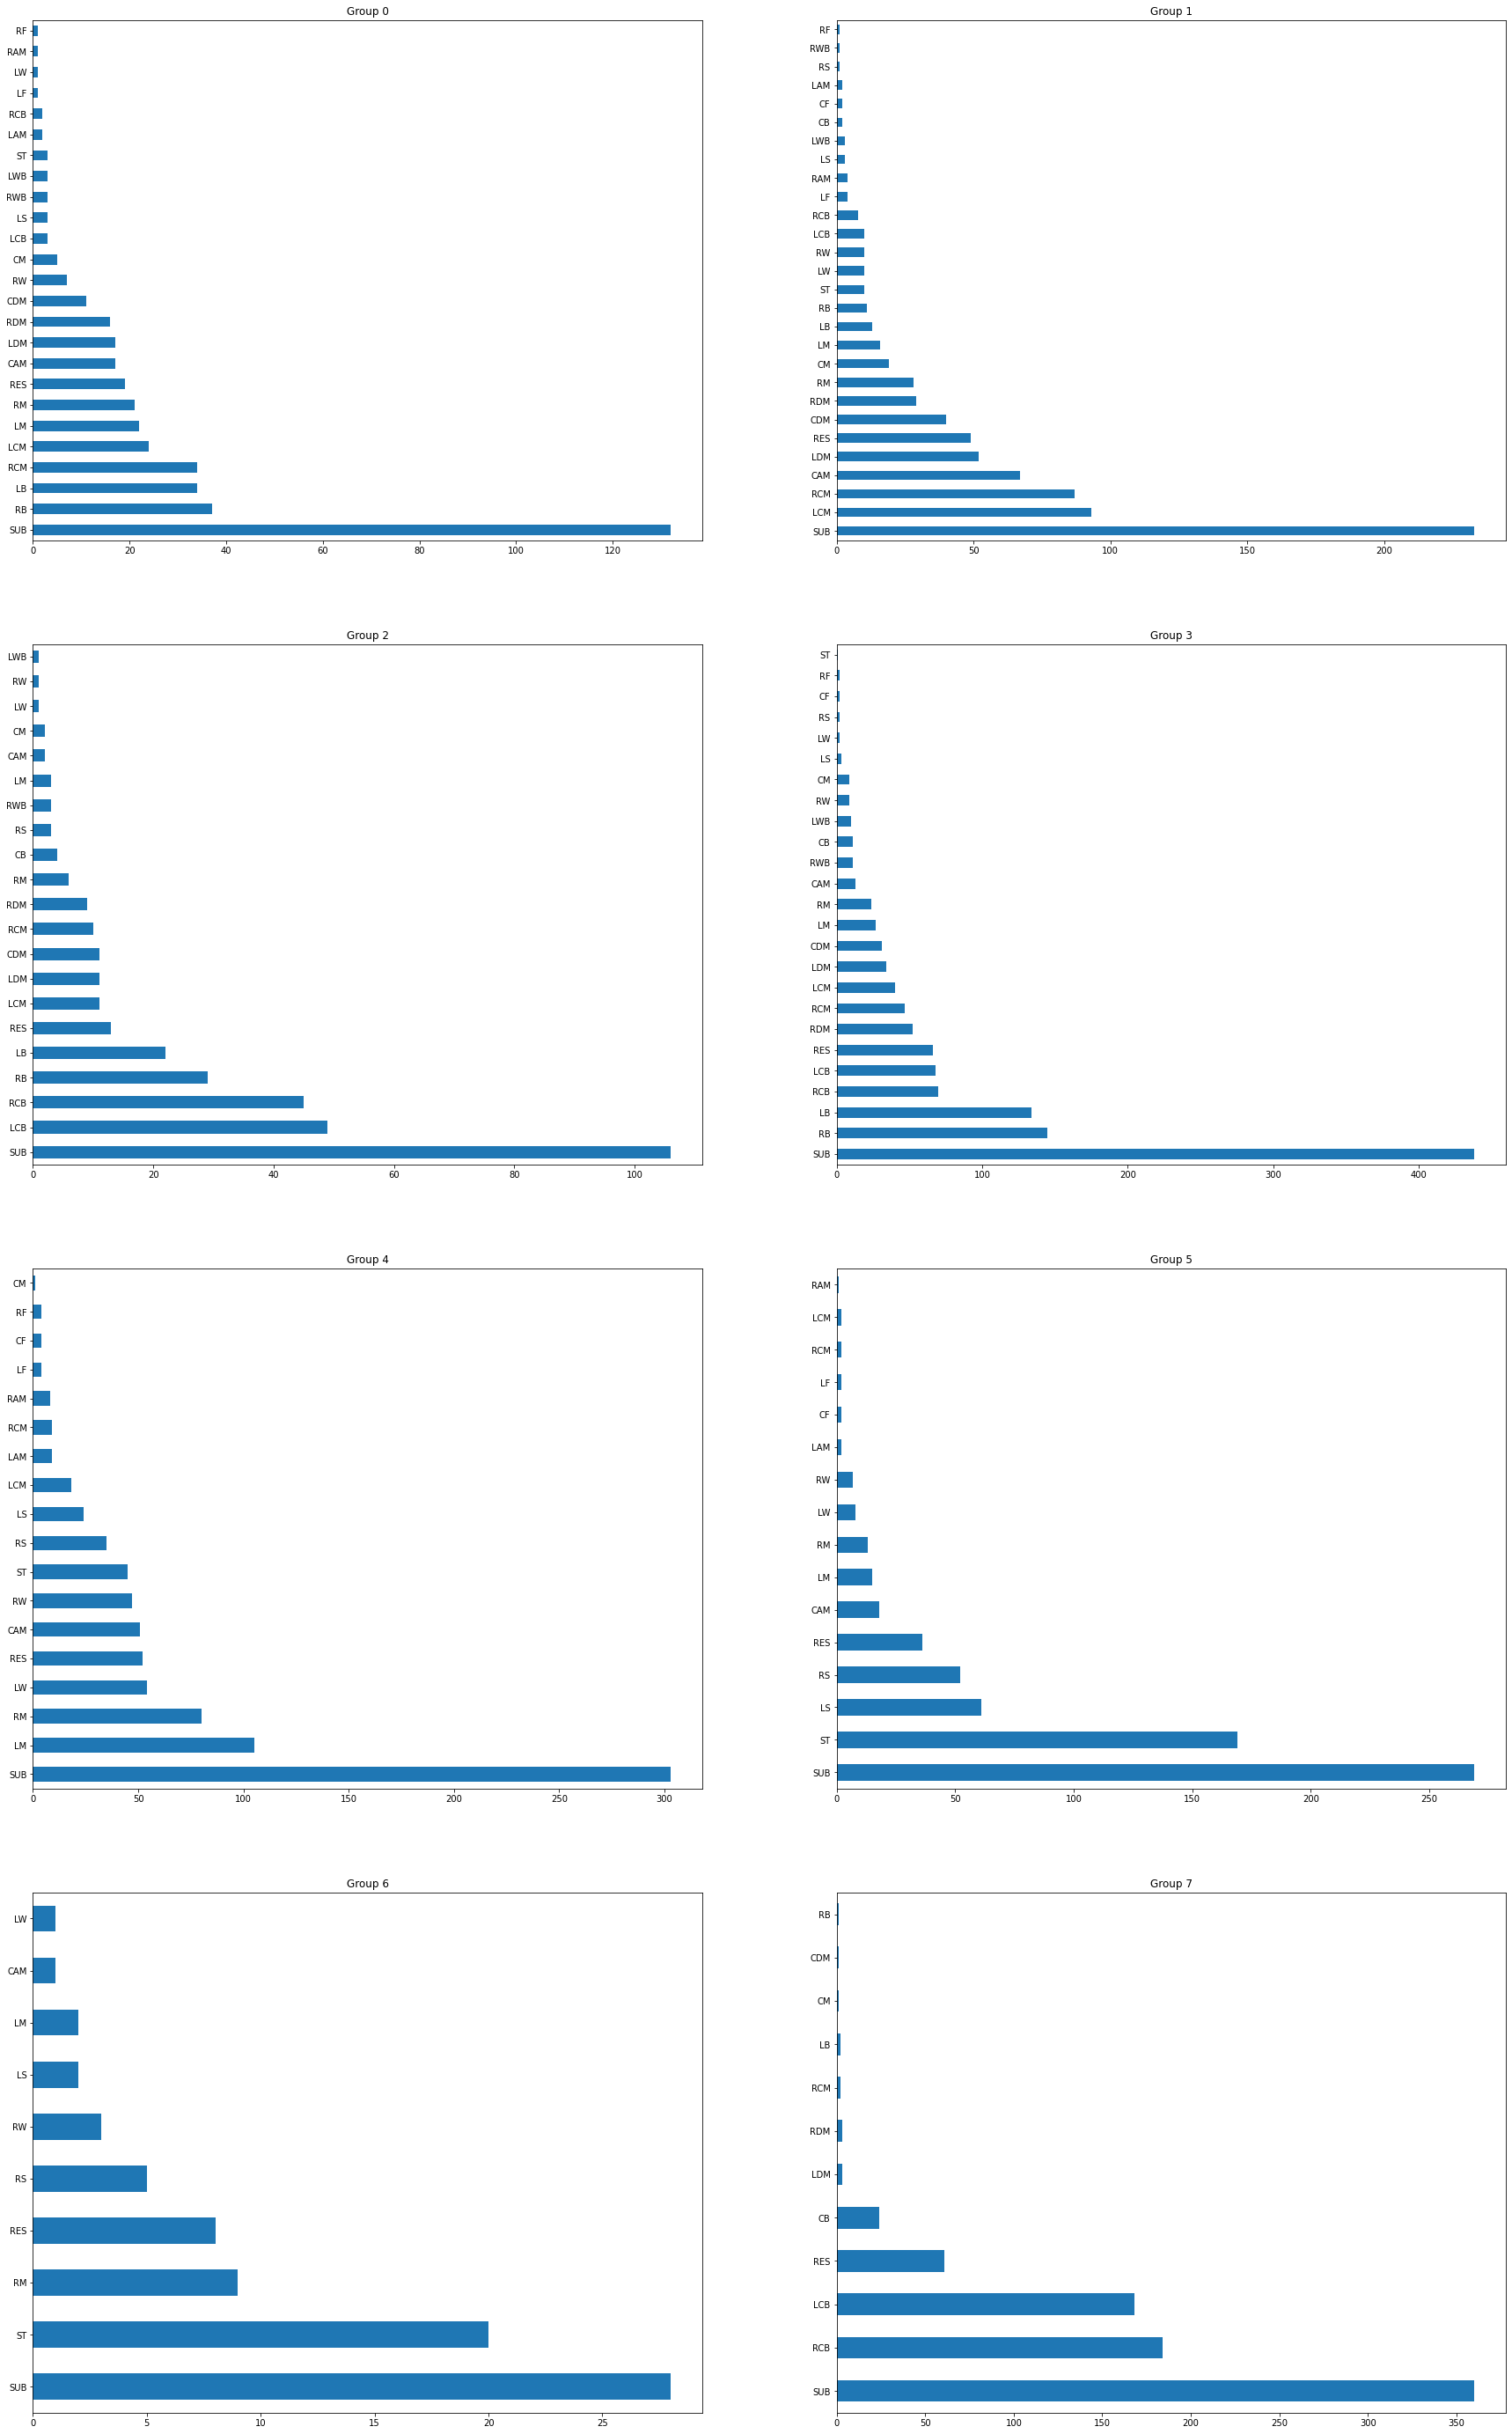

In [41]:
df_meanshift = df_without_GK.copy()
df_meanshift['group_label'] = ms.labels_ 
column_name = 'team_position'
fig, axs = plt.subplots(4, 2, figsize=(30, 50), sharey=False)
get_colum_series_by_group(df_ms_no_GK, column_name, 0).value_counts().plot(kind='barh', title='Group 0', ax=axs[0][0] )
get_colum_series_by_group(df_ms_no_GK, column_name, 1).value_counts().plot(kind='barh', title='Group 1', ax=axs[0][1] )
get_colum_series_by_group(df_ms_no_GK, column_name, 2).value_counts().plot(kind='barh', title='Group 2', ax=axs[1][0] )
get_colum_series_by_group(df_ms_no_GK, column_name, 3).value_counts().plot(kind='barh', title='Group 3', ax=axs[1][1] )
get_colum_series_by_group(df_ms_no_GK, column_name, 4).value_counts().plot(kind='barh', title='Group 4', ax=axs[2][0] )
get_colum_series_by_group(df_ms_no_GK, column_name, 5).value_counts().plot(kind='barh', title='Group 5', ax=axs[2][1] )
get_colum_series_by_group(df_ms_no_GK, column_name, 6).value_counts().plot(kind='barh', title='Group 6', ax=axs[3][0] )
get_colum_series_by_group(df_ms_no_GK, column_name, 7).value_counts().plot(kind='barh', title='Group 7', ax=axs[3][1] )
